# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Create training set and define training dataloader
## YOUR CODE HERE ##
training_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(training_data, batch_size= 100, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size= 100)

In [3]:
len(train_loader)

600

In [4]:
len(test_loader)

100

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**DOUBLE CLICK THIS CELL TO MODIFY**
The digits have been size-normalized and centered in a fixed-size image. no need for preprocessing and formatting.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


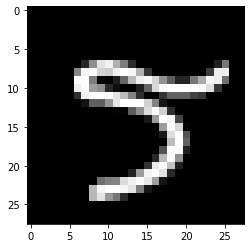

Label: 5


In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [31]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:32]
    images = batch[0][0:32]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

8


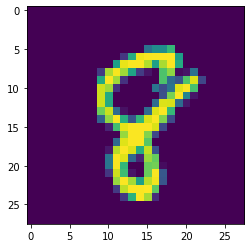

8


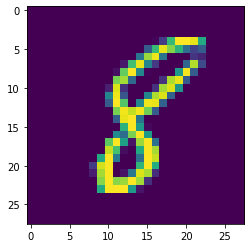

7


9


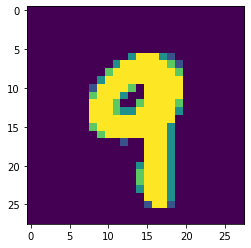

3


In [32]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [6]:
## YOUR CODE HERE ##
# Define the class for your neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
## YOUR CODE HERE ##
# Choose an optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9) 

# Choose a loss function
criterion =  nn.CrossEntropyLoss() 
#criterion = nn.NLLLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
## YOUR CODE HERE ##
num_epochs = 5

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for inputs, labels  in train_loader:   # for i, data in enumerate(train_loader): 
        # data is a list of [inputs, labels]
        #inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item() 

        train_loss += loss.item()
    
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()   

        val_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 87.70% training loss: 0.41904
Epoch 1 validation accuracy: 92.76% validation loss: 0.23916
Epoch 2 training accuracy: 93.83% training loss: 0.20728
Epoch 2 validation accuracy: 93.97% validation loss: 0.18841
Epoch 3 training accuracy: 95.49% training loss: 0.14789
Epoch 3 validation accuracy: 95.64% validation loss: 0.13775
Epoch 4 training accuracy: 96.38% training loss: 0.11722
Epoch 4 validation accuracy: 96.22% validation loss: 0.12237
Epoch 5 training accuracy: 97.07% training loss: 0.09627
Epoch 5 validation accuracy: 96.81% validation loss: 0.09708


Plot the training loss (and validation loss/accuracy, if recorded).

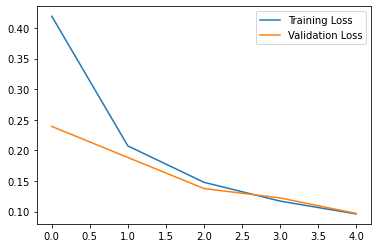

In [9]:
## YOUR CODE HERE ##
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
## YOUR CODE HERE ##
test_loss = 0.0
test_correct = 0
net.eval()
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)
    test_correct += (preds == labels).sum().item()  

    test_loss += loss.item()
    #print(test_loss)

print(f'test accuracy: {test_correct/len(test_loader):.2f}% test loss: {test_loss/len(test_loader):.5f}')


100
test accuracy: 96.81% test loss: 0.09708


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [13]:
## YOUR CODE HERE ##
# NO need for hyperparameters tuning as the test accuracy: 96.81%  and the test loss: 0.09708

## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
## YOUR CODE HERE ##
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

#Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

PATH = "./data"
torch.save(net.state_dict(), os.path.join(PATH,"mymodel1statedic.pth"))  #Save/Load state_dict (Recommended)
torch.save(net, os.path.join(PATH,"mymodel1.pth"))   #Save/Load Entire Model

Model's state_dict:
fc1.weight 	 torch.Size([120, 784])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {0: {'step': 3000, 'exp_avg': tensor([[-6.8705e-05, -6.8705e-05, -6.8705e-05,  ..., -6.8705e-05,
         -6.8705e-05, -6.8705e-05],
        [ 4.7000e-04,  4.7000e-04,  4.7000e-04,  ...,  4.7000e-04,
          4.7000e-04,  4.7000e-04],
        [-5.6052e-45, -5.6052e-45, -5.6052e-45,  ..., -5.6052e-45,
         -5.6052e-45, -5.6052e-45],
        ...,
        [-3.9742e-04, -3.9742e-04, -3.9742e-04,  ..., -3.9742e-04,
         -3.9742e-04, -3.9742e-04],
        [-5.6052e-45, -5.6052e-45, -5.6052e-45,  ..., -5.6052e-45,
         -5.6052e-45, -5.6052e-45],
        [-5.6052e-45, -5.6052e-45, -5.6052e-45,  ..., -5.6052e-45,
         -5.6052e-45, -5.6052e-45]]), 'exp_avg_sq': tensor([[4.8205e-06, 4.8205e-06, 4.8205e-06,  ..., 4.8205e-06, 4.8205e-06,
      

In [12]:
#load model again for inference, knote Model class must be defined somewhere
mymodelagin = torch.load(os.path.join(PATH,"mymodel1.pth"))
mymodelagin.eval()
mymodelagin

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Contextualize your model – based on the results from Yann LeCun’s webpage, how does your model rank?
For training I used neural network with 1 input layer, 2 hidden layers, and 1 output layer, with RELU() activation function on the hidden layers only. also i used  Adam optimizer with learning rate = 0.001, and crossentropy loss function. I got test accuracy of 96.81% and test loss = 0.09708. My model ranked better than the published work in Yann LeCun’s webpage